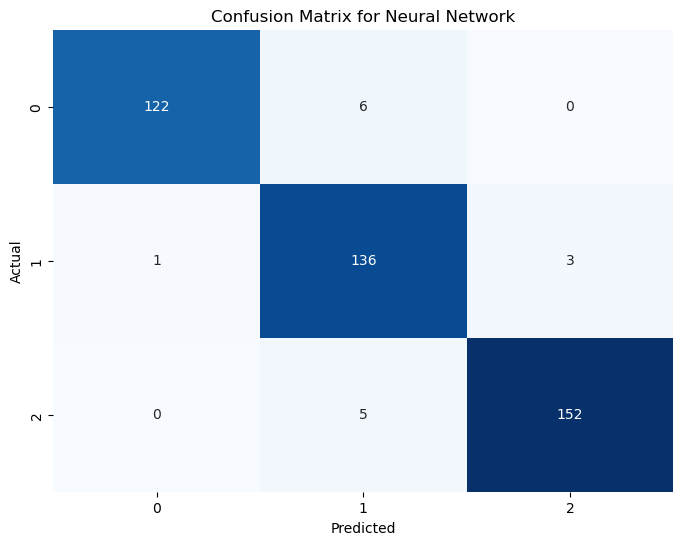

In [ ]:
# Necessary imports
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import os

# Load the dataset 
data = pd.read_excel('data_label_26-7-2025 -ln.xlsx')


# Define features and target
feature_list = feature_list = ['log-Hue', 'Saturation', 'b* lab']
X = data[feature_list]
y = data['Classification_label']

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load shelf-life data for separate evaluation
X_shelf_life = pd.read_excel('shelf_life_data_f.xlsx')
y_shelf_life = X_shelf_life['real_code']
X_shelf_scaled = scaler.transform(X_shelf_life[feature_list])

# Classifier configurations for GridSearchCV
param_grids = {

       'Neural Network': {
        'model': MLPClassifier(max_iter=3000, random_state=42),
        'param_grid': {
            'hidden_layer_sizes': [(50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [ 0.01],             # L2 regularization
            'learning_rate': ['constant'],  # learning rate strategy
        }
}
}
# Store evaluation results
results = []

# Evaluate classifiers with hyperparameter tuning
for name, config in param_grids.items():
    model = config['model']
    param_grid = config['param_grid']

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Compute test accuracy and confusion matrix
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute precision, recall, and F1 scores
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Compute weighted scores
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = cv_scores.mean()
    std_cv_accuracy = cv_scores.std()

    # Evaluate on shelf-life data
    y_shelf_pred = best_model.predict(X_shelf_scaled)
    shelf_life_accuracy = accuracy_score(y_shelf_life, y_shelf_pred)
    print(y_shelf_pred)

    # Plot ROC Curve for each class
    if hasattr(best_model, "predict_proba"):  # Check if model supports probabilities
        y_test_binarized = label_binarize(y_test, classes=np.unique(y))
        y_score = best_model.predict_proba(X_test_scaled)

        plt.figure(figsize=(10, 7))
        for i, class_label in enumerate(np.unique(y)):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            auc_score = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.4f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve per Class for {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    # Append model results
    results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': conf_matrix.tolist(),
        'Precision (per class)': precision_per_class.tolist(),
        'Recall (per class)': recall_per_class.tolist(),
        'F1 Score (per class)': f1_per_class.tolist(),
        'Weighted Precision': weighted_precision,
        'Weighted Recall': weighted_recall,
        'Weighted F1 Score': weighted_f1,
        'Mean CV Accuracy (10-fold)': mean_cv_accuracy,
        'Std CV Accuracy (10-fold)': std_cv_accuracy,
        'Shelf Life Accuracy': shelf_life_accuracy
    })
    model_filename = f"{name.replace(' ', '_').lower()}_model.joblib"
    joblib.dump(best_model, model_filename)
    print(f"{name} saved as {model_filename}")
# Convert results to DataFrame and save to CSV
joblib.dump(scaler, "standard_scaler.joblib")
print("Scaler saved as 'standard_scaler.joblib'")
print(model.get_params())
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results_with_roc_conf_matrix.csv', index=False)
print("Results have been saved to 'model_evaluation_results_with_roc_conf_matrix.csv'.")


In [7]:
import pandas as pd

def ann_summary(model, X_train, y_train=None, task="classification"):
    """
    Generate ANN hyperparameter summary table for MLPRegressor or MLPClassifier.
    
    Parameters
    ----------
    model : trained scikit-learn model (MLPRegressor or MLPClassifier)
    X_train : pd.DataFrame or np.ndarray, input features used for training
    y_train : array-like, target values (needed for classification)
    task : str, "regression" or "classification"
    
    Returns
    -------
    summary_df : pd.DataFrame
    """
    # Input features count
    input_features = X_train.shape[1]
    
    # Output neurons
    if task == "regression":
        output_neurons = 1
        output_activation = "Linear"
    else:  # classification
        output_neurons = len(model.classes_)
        output_activation = "Softmax"
    
    summary = pd.DataFrame({
        "Parameter": [
            "Input features",
            "Hidden layers",
            "Activation (hidden)",
            "Solver",
            "Alpha (L2 penalty)",
            "Learning rate schedule",
            "Learning rate init",
            "Max iterations",
            "Random state",
            "Output neurons",
            "Output activation"
        ],
        "Value": [
            input_features,
            model.hidden_layer_sizes,
            model.activation,
            model.solver,
            model.alpha,
            model.learning_rate,
            model.learning_rate_init,
            model.max_iter,
            model.random_state,
            output_neurons,
            output_activation
        ]
    })
    
    return summary

# Example usage:
summary_table = ann_summary(best_model, X_train, y_train, task="classification")
print(summary_table)


                 Parameter     Value
0           Input features         3
1            Hidden layers  (50, 50)
2      Activation (hidden)      relu
3                   Solver      adam
4       Alpha (L2 penalty)      0.01
5   Learning rate schedule  constant
6       Learning rate init     0.001
7           Max iterations      3000
8             Random state        42
9           Output neurons         3
10       Output activation   Softmax


In [56]:
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, probplot
import time
import threading

# Load the dataset 
data = pd.read_excel('data_label_26_7-2025 -ln.xlsx')


# Features and target variable
feature_list = ['log-Hue', 'Saturation', 'b* lab']
X = data[feature_list]
y = data['mg N/100g']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids for hyperparameter tuning
param_grids = {

    'Neural Network': {
        'hidden_layer_sizes': [(50, 50)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [ 0.01],
        'learning_rate': ['constant'],
        'max_iter': [3000,]
    },


    'SVR': {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    },
    'Linear Regression': {},
 }

# Models to tune
regressors = {
 
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),   'Neural Network': MLPRegressor(random_state=42, max_iter=3000)}

# CPU protection settings
CPU_THRESHOLD = 85  # in percentage
CHECK_INTERVAL = 5  # in seconds


def monitor_cpu():
    """Monitor CPU usage and stop the process if it exceeds the threshold."""
    while True:
        cpu_usage = psutil.cpu_percent(interval=1)
        if cpu_usage > CPU_THRESHOLD:
            print(f"CPU usage {cpu_usage}% exceeded the threshold of {CPU_THRESHOLD}%")
            raise SystemExit("CPU usage too high. Terminating process to protect the system.")
        time.sleep(CHECK_INTERVAL)


# Start monitoring CPU usage in a separate thread
cpu_monitor_thread = threading.Thread(target=monitor_cpu)
cpu_monitor_thread.daemon = True  # Daemon thread will exit when the main program exits
cpu_monitor_thread.start()

# For saving results
results = []

# Load shelf life data
X_shelf_life = pd.read_excel('shelf_life_data_f.xlsx')
y_shelf_life = X_shelf_life['Experimental (N mg/100g)']

# Hyperparameter tuning using GridSearchCV
for name, model in regressors.items():
    if name in param_grids:  # Only do grid search if there is a parameter grid
        print(f"Performing Grid Search for {name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='r2', n_jobs=2)  # Limit to 2 cores
        grid_search.fit(X_train_scaled, y_train)

        # Get the best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {name}: {best_params}")

        # Predict and evaluate the best model on test data
        y_pred = best_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmsep = np.sqrt(mse)  # RMSEP calculation
        r2 = r2_score(y_test, y_pred)

        # RMSECV calculation
        rmsecv_scores = -cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
        rmsecv = np.sqrt(rmsecv_scores.mean())
        rmsecv_std = rmsecv_scores.std()

        # Cross-validated R²
        r2_cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='r2')
        r2_cv = r2_cv_scores.mean()
        r2_cv_std = r2_cv_scores.std()

        # Shelf life prediction
        X_shelf_scaled = scaler.transform(X_shelf_life[feature_list])
        y_shelf_pred = best_model.predict(X_shelf_scaled)
        print(y_shelf_pred)
        shelf_life_accuracy = r2_score(y_shelf_life, y_shelf_pred)
        mse_shelf = mean_squared_error(y_shelf_life, y_shelf_pred)
        rmsep_shelf = np.sqrt(mse_shelf)  # RMSEP calculation

        # Save the results for comparison
        results.append([feature_list, name, best_params, rmsep, rmsecv, rmsecv_std, r2, r2_cv, r2_cv_std, shelf_life_accuracy])

        print(f"Model: {name}, Test RMSEP: {rmsep:.4f}, Test RMSECV: {rmsecv:.4f} ± {rmsecv_std:.4f}, "
              f"Test R²: {r2:.4f}, Cross-validated R²: {r2_cv:.4f} ± {r2_cv_std:.4f}, Shelf Life R²: {shelf_life_accuracy:.4f},mse_shelf {mse_shelf}")

# Save results to CSV
results_df = pd.DataFrame(results, columns=['Features', 'Model', 'Best Params', 'RMSEP', 'RMSECV', 'RMSECV Std Dev', 'Test R²', 'Cross-validated R²', 'R² CV Std Dev', 'Shelf Life R²'])
results_df.to_csv('regression_model_results_with_tuning.csv', index=False)
print("Model evaluation results saved with hyperparameter tuning.")


Performing Grid Search for SVR...
Best parameters for SVR: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
[ 5.16285782  8.99523137 10.03152672 16.9840046  14.81704516]
Model: SVR, Test RMSEP: 2.4538, Test RMSECV: 2.1768 ± 1.2346, Test R²: 0.8887, Cross-validated R²: 0.9181 ± 0.0224, Shelf Life R²: 0.3187,mse_shelf 32.47590159871911
Performing Grid Search for Linear Regression...
Best parameters for Linear Regression: {}
[ 3.39929449  9.66320581 12.08927738 15.23741989 22.13223694]
Model: Linear Regression, Test RMSEP: 3.7086, Test RMSECV: 3.5425 ± 2.6795, Test R²: 0.7458, Cross-validated R²: 0.7862 ± 0.0335, Shelf Life R²: 0.7894,mse_shelf 10.04028328585054
Performing Grid Search for Neural Network...
Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}
[ 5.56132246  7.5537993  10.57999633 16.5282111  25.09531329]
Model: Neural Network, Test RMSEP: 2.4310, Test RMSECV: 2.

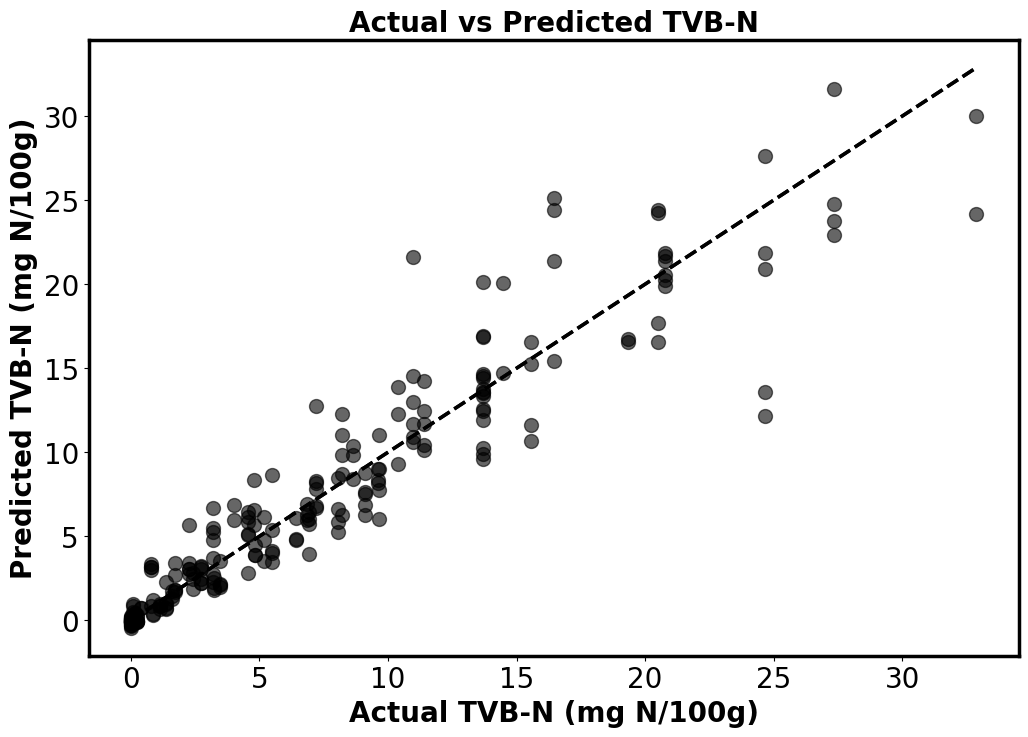

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_pred = best_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)

# Start fresh (no style preset)
plt.rcParams.update(plt.rcParamsDefault)

# Plot
fig, ax = plt.subplots(figsize=(12,8))

# Set pure white background for figure and axes
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Scatter plot (black dots, no edge stroke)
ax.scatter(y_test, y_pred, color='black', alpha=0.6, s=100, label='Predicted vs Actual')

# Perfect fit line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color='black', linewidth=2.5, linestyle='--', label='Perfect Fit')

# Perfect fit line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color='black', linewidth=2.5, linestyle='--', label='Perfect Fit')

# Axis labels and title
ax.set_xlabel('Actual TVB-N (mg N/100g)', fontsize=20, weight='bold')
ax.set_ylabel('Predicted TVB-N (mg N/100g)', fontsize=20, weight='bold')
ax.set_title('Actual vs Predicted TVB-N', fontsize=20, weight='bold')

# R² annotation
# ax.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', transform=ax.transAxes,
#         fontsize=28, weight='bold', verticalalignment='top')

# Ticks
ax.tick_params(axis='both', labelsize=20)

# Thicker black borders
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')

# Legend


# Final layout

plt.show()


In [18]:
# Load shelf life data
X_shelf_life = pd.read_excel('shelf_life_data_f.xlsx')
y_shelf_life = X_shelf_life['Experimental (N mg/100g)']
 # Shelf life prediction


X_shelf_scaled = scaler.transform(X_shelf_life[feature_list])
y_shelf_pred = best_model.predict(X_shelf_scaled)
print(y_shelf_pred)



[ 3.73084013  9.60113007 11.8228285  15.22862167 21.50821751]
